# Comparing npSF and tfSF via IB (Simulation 2)

In this notebook we compare npSF and tfSF using the IB, reproducing some of the experiments in [1].

## Setup

We start by importing some libraries:

In [1]:
import numpy as np
import joblib
import sklearn.datasets as ds
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

import tfSF
import npSF

import data.data_creation as D
from IT import IT

We define the parameters of our simulation:

In [2]:
learned_features = 2
n_epochs = 200

IT_bins=30

We define a couple of helper functions: a simple linear regression function and a helper function to compute the tfSF learned representation as a function of the weights. Notice that here, for simplicity, we call the steps of SF implemented using *numpy*; since no learning is now required, using *numpy* saves us the overhead of instantiating a *tensorflow* model.

In [3]:
def linreg(x,y):
    a, b, _, _, _ = stats.linregress(x,y)
    return a*x+b
    

def computeZ(X,W):
    WX = np.dot(W,X.T)
    F = npSF.softabsolute(WX)
    Fsquish, _ = npSF.l2row(F)
    Fhat, _ = npSF.l2row(Fsquish.T)
    Z = Fhat
    return Z

## Simulation 2 from [1]

We now reproduce the results for *Simulation 2* in [1]. We generate random data.

In [4]:
data = D.get_samples_multivariate_gaussians_ND(n_samples_train=900, 
                                            n_samples_test=100, 
                                            mu = stats.uniform.rvs(loc=-5,scale=10,size=4), 
                                            sigma = ds.make_spd_matrix(4))

We train the tfSF module.

In [5]:
tfsf = tfSF.SFilter(n_features=learned_features)
tfsf.fit(data['X_tr'], epochs=n_epochs, batchsize=900)

Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 1163.9366
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 1171.9016
Epoch 3/200
1/1 [==============================] - 0s 2ms/step - loss: 1151.6235
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 1145.5496
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 1141.5623
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 1132.1880
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 1119.3481
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 1110.8595
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 1109.8191
Epoch 10/200
1/1 [==============================] - 0s 3ms/step - loss: 1109.7340
Epoch 11/200
1/1 [==============================] - 0s 2ms/step - loss: 1110.0210
Epoch 12/200
1/1 [==============================] - 0s 2ms/step - loss: 1111.0874
Epoch 13/200
1/1 [======

1/1 [==============================] - 0s 2ms/step - loss: 1098.3994
Epoch 101/200
1/1 [==============================] - 0s 2ms/step - loss: 1098.3918
Epoch 102/200
1/1 [==============================] - 0s 3ms/step - loss: 1098.3553
Epoch 103/200
1/1 [==============================] - 0s 2ms/step - loss: 1098.2764
Epoch 104/200
1/1 [==============================] - 0s 2ms/step - loss: 1098.2051
Epoch 105/200
1/1 [==============================] - 0s 3ms/step - loss: 1098.2211
Epoch 106/200
1/1 [==============================] - 0s 2ms/step - loss: 1098.2151
Epoch 107/200
1/1 [==============================] - 0s 1ms/step - loss: 1098.2205
Epoch 108/200
1/1 [==============================] - 0s 3ms/step - loss: 1098.1445
Epoch 109/200
1/1 [==============================] - 0s 3ms/step - loss: 1098.1089
Epoch 110/200
1/1 [==============================] - 0s 2ms/step - loss: 1098.0702
Epoch 111/200
1/1 [==============================] - 0s 2ms/step - loss: 1098.0404
Epoch 112/200
1/1 

Epoch 197/200
1/1 [==============================] - 0s 2ms/step - loss: 1097.0378
Epoch 198/200
1/1 [==============================] - 0s 2ms/step - loss: 1097.0304
Epoch 199/200
1/1 [==============================] - 0s 2ms/step - loss: 1096.9688
Epoch 200/200
1/1 [==============================] - 0s 4ms/step - loss: 1096.9839


We train the npSF module.

In [6]:
npsf = npSF.SFilter()
npsf.setFeatures(learned_features)
npsf.setTrainData(data['X_tr'])
npsf.initializeWeights()
npsf.initialiazeNotebook()
npsf.train()

We plot the loss function to verify that the models converged to a solution.

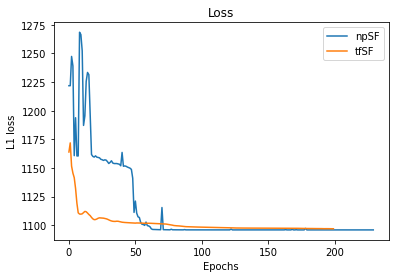

In [7]:
plt.title('Loss'); 
plt.xlabel('Epochs'); 
plt.ylabel('L1 loss');

plt.plot(npsf.notebook['losses'],label='npSF')
plt.plot(tfsf.hist.history['loss'],label='tfSF')
plt.legend()

We compute the information-theoretic statistics of interest (entropy and mutual information) at each iteration.

In [8]:
npWs = npsf.notebook['weights']    
    
np_Z_tes = []; np_MI_XZs = []; np_H_Zs = []  
for W in npWs:
    Z_te = computeZ(data['X_te'],W)
    
    np_Z_tes.append(Z_te)
    np_MI_XZs.append(IT.compute_MI_dd_bin(data['X_te'],Z_te,n_bins=IT_bins))
    np_H_Zs.append(IT.compute_H_bin(Z_te,n_bins=IT_bins))


tfWs = tfsf.weights

tf_Z_tes = []; tf_MI_XZs = []; tf_H_Zs = []  
for W in tfWs:
    Z_te = computeZ(data['X_te'],W)
    
    tf_Z_tes.append(Z_te)
    tf_MI_XZs.append(IT.compute_MI_dd_bin(data['X_te'],Z_te,n_bins=IT_bins))
    tf_H_Zs.append(IT.compute_H_bin(Z_te,n_bins=IT_bins))

In [9]:
Z_trs = []
for W in tfWs:
    Z_tr = computeZ(data['X_tr'],W)
    Z_trs.append(Z_tr)

We plot entropy and mutual information.

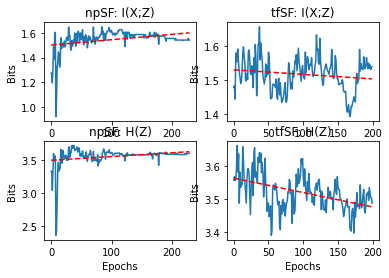

In [10]:
_,ax = plt.subplots(2,2)

ax[0,0].plot(np_MI_XZs)
ax[0,0].set_title('npSF: I(X;Z)')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Bits')
ax[0,0].plot(linreg(np.arange(len(np_MI_XZs)),np_MI_XZs),'r--')

ax[0,1].plot(tf_MI_XZs)
ax[0,1].set_title('tfSF: I(X;Z)')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Bits')
ax[0,1].plot(linreg(np.arange(n_epochs),tf_MI_XZs),'r--')

ax[1,0].plot(np_H_Zs)
ax[1,0].set_title('npSF: H(Z)')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Bits')
ax[1,0].plot(linreg(np.arange(len(np_H_Zs)),np_H_Zs),'r--')

ax[1,1].plot(tf_H_Zs)
ax[1,1].set_title('tfSF: H(Z)')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Bits')
ax[1,1].plot(linreg(np.arange(n_epochs),tf_H_Zs),'r--')

And the information graphs.

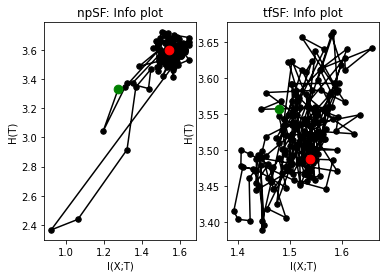

In [11]:
_,ax = plt.subplots(1,2)

ax[0].set_title('npSF: Info plot'); 
ax[0].set_xlabel('I(X;T)'); 
ax[0].set_ylabel('H(T)'); 
ax[0].plot(np_MI_XZs,np_H_Zs,c='black', zorder=0)
ax[0].scatter(np_MI_XZs[1:-1],np_H_Zs[1:-1],c='black',s=30, zorder=1)
ax[0].scatter(np_MI_XZs[0],np_H_Zs[0],c='green',s=75,zorder=2)
ax[0].scatter(np_MI_XZs[-1],np_H_Zs[-1],c='red',s=75,zorder=2)

ax[1].set_title('tfSF: Info plot'); 
ax[1].set_xlabel('I(X;T)'); 
ax[1].set_ylabel('H(T)'); 
ax[1].plot(tf_MI_XZs,tf_H_Zs,c='black', zorder=0)
ax[1].scatter(tf_MI_XZs[1:-1],tf_H_Zs[1:-1],c='black',s=30, zorder=1)
ax[1].scatter(tf_MI_XZs[0],tf_H_Zs[0],c='green',s=75,zorder=2)
ax[1].scatter(tf_MI_XZs[-1],tf_H_Zs[-1],c='red',s=75,zorder=2)

## Conclusions

- Results do NOT match results in  [1]

### References

[1] Zennaro, F.M. and Chen, K., 2019. Towards Further Understanding of Sparse Filtering via Information Bottleneck. arXiv preprint arXiv:1910.08964.